## Summary of Results

### Best Pipeline Performance
**Winner: Char-enhanced (Word + Char TF-IDF)**
- **Val Macro-F1: 0.9245** (92.45%)
- **CV Macro-F1: 0.9199 ± 0.0024**
- **Feature dimension: 100,000**
- **Validation accuracy: 92.47%**

### Full Pipeline Rankings

1. **Char-enhanced**: 0.9245 (best - combines word and character n-grams)
2. **Baseline TF-IDF**: 0.9207 (strong baseline)
3. **Augmented**: 0.9203 (TF-IDF + document features)
4. **Chi2 selected**: 0.9170 (reduced features, slight performance drop)
5. **Embedding concat**: 0.8913 (dense embeddings underperform sparse)
6. **SVD reduced**: 0.8866 (dimensionality reduction hurts)
7. **Embedding TF-IDF**: 0.8792 (pure embeddings lowest)

## Key Insights

1. **Sparse features beat dense**: TF-IDF (sparse) significantly outperforms embeddings (dense) for AG News classification
2. **Character n-grams help**: Adding character (3,5)-grams improved performance by ~0.4% over word-only
3. **Document features minimal impact**: Adding 12 auxiliary features didn't significantly improve baseline TF-IDF
4. **Feature selection trades accuracy**: Chi2 reducing 50k→20k features dropped 0.4% macro-F1
5. **Dimensionality reduction harmful**: SVD destroyed ~3.5% performance


# Notebook 3: Data Preprocessing & Text Engineering
## This notebook implements Step 3 of the Roadmap: Preprocessing Pipeline

### Imports


In [4]:
# Data handling
import pandas as pd
import numpy as np
import re
import sys
import joblib
from pathlib import Path
import sklearn

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import contractions

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp

# Embeddings
import gensim.downloader as api
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Model validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

print(f"Python Version: {sys.version}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"NLTK Version: {nltk.__version__}")
print(f"spaCy Version: {spacy.__version__}")
print(f"scikit-learn Version: {sklearn.__version__}")


Python Version: 3.11.14 (main, Oct 31 2025, 23:04:14) [Clang 21.1.4 ]
Pandas Version: 2.3.3
Numpy Version: 1.26.4
NLTK Version: 3.9.2
spaCy Version: 3.7.5
scikit-learn Version: 1.7.2


### 1. Load preprocessed data from Notebook 01


In [5]:
# 1. Load preprocessed data from Notebook 01
train_df = pd.read_csv("../data/processed/train.csv")
val_df = pd.read_csv("../data/processed/val.csv")
test_df = pd.read_csv("../data/processed/test.csv")

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Test: {test_df.shape}")


Train: (102000, 3)
Val: (18000, 3)
Test: (7600, 3)


### 3.1 Text Cleaning Pipeline Design - Modular Functions


In [6]:
def basic_lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

def normalize_whitespace(text):
    """Replace tabs, multiple spaces, newlines with single space"""
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_html_urls(text):
    """Strategy 1: Remove HTML tags and URLs completely"""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    return text

def replace_html_urls_tokens(text):
    """Strategy 2: Replace with tokens"""
    text = re.sub(r'http\S+|www\.\S+', '<URL>', text)
    text = re.sub(r'\S+@\S+', '<EMAIL>', text)
    text = re.sub(r'<[^>]+>', '', text)
    return text

def keep_html_urls(text):
    """Strategy 3: Keep as-is"""
    return text

def remove_punctuation(text):
    """Remove all punctuation"""
    return re.sub(r'[^\w\s]', ' ', text)

def keep_punctuation(text):
    """Keep punctuation as-is"""
    return text

def replace_numbers_token(text):
    """Replace numbers with <NUM> token"""
    return re.sub(r'\d+', '<NUM>', text)

def keep_numbers(text):
    """Keep numbers as-is"""
    return text

def fix_encoding(text):
    """Handle Unicode errors and HTML entities"""
    import html
    text = html.unescape(text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return text

def expand_contractions(text):
    """Expand contractions using contractions library"""
    return contractions.fix(text)

print("Text cleaning functions defined")


Text cleaning functions defined


### Combined cleaning pipelines


In [7]:
def clean_basic(text):
    """Basic cleaning: whitespace normalization only"""
    text = normalize_whitespace(text)
    return text

def clean_aggressive(text):
    """Aggressive cleaning: lowercase, remove HTML/URLs, remove punctuation"""
    text = basic_lowercase(text)
    text = normalize_whitespace(text)
    text = remove_html_urls(text)
    text = remove_punctuation(text)
    text = replace_numbers_token(text)
    return text

def clean_moderate(text):
    """Moderate cleaning: lowercase, replace URLs with tokens, keep punctuation"""
    text = basic_lowercase(text)
    text = normalize_whitespace(text)
    text = replace_html_urls_tokens(text)
    text = keep_punctuation(text)
    text = keep_numbers(text)
    return text

def clean_minimal(text):
    """Minimal cleaning: whitespace normalization, fix encoding"""
    text = normalize_whitespace(text)
    text = fix_encoding(text)
    return text

def clean_with_expansion(text):
    """Cleaning with contraction expansion"""
    text = basic_lowercase(text)
    text = expand_contractions(text)
    text = normalize_whitespace(text)
    text = replace_html_urls_tokens(text)
    return text

print("Combined cleaning pipelines defined")

Combined cleaning pipelines defined


### 3.2 Tokenization Strategies


In [8]:
# Tokenization Functions
def tokenize_whitespace(text):
    """Simple whitespace tokenization"""
    return text.split()

def tokenize_nltk(text):
    """NLTK word tokenization"""
    return word_tokenize(text)

def tokenize_spacy(text):
    """spaCy tokenization"""
    doc = nlp(text)
    return [token.text for token in doc]

def tokenize_regex_word(text):
    """Regex word boundary tokenization"""
    return re.findall(r'\b\w+\b', text)

def tokenize_regex_alphanum(text):
    """Regex alphanumeric tokenization"""
    return re.findall(r'\w+', text)

def tokenize_sentences_nltk(text):
    """NLTK sentence tokenization"""
    return sent_tokenize(text)

def tokenize_sentences_spacy(text):
    """spaCy sentence tokenization"""
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

print("Tokenization functions defined")


Tokenization functions defined


### Test tokenization methods on sample


In [9]:
# 1. Tokenization
sample_text = train_df['text'].iloc[0]
print(f"Original text: {sample_text[:200]}...")
print(f"\nWhitespace tokens: {len(tokenize_whitespace(sample_text))} tokens")
print(f"NLTK tokens: {len(tokenize_nltk(sample_text))} tokens")
print(f"spaCy tokens: {len(tokenize_spacy(sample_text))} tokens")
print(f"Regex word tokens: {len(tokenize_regex_word(sample_text))} tokens")
print(f"Regex alphanum tokens: {len(tokenize_regex_alphanum(sample_text))} tokens")


Original text: Brief: Siemens warns of ear damage from loud mobile tune Siemens warned customers of a software defect in a range of mobile phones that could cause hearing damage....

Whitespace tokens: 28 tokens
NLTK tokens: 30 tokens
spaCy tokens: 30 tokens
Regex word tokens: 28 tokens
Regex alphanum tokens: 28 tokens


### 3.3 Text Normalization Techniques - Stop Word Removal


In [10]:
# Load stop word lists
nltk_stopwords = set(stopwords.words('english'))
spacy_stopwords = nlp.Defaults.stop_words

print(f"NLTK stopwords: {len(nltk_stopwords)} words")
print(f"spaCy stopwords: {len(spacy_stopwords)} words")
print(f"Overlap: {len(nltk_stopwords.intersection(spacy_stopwords))} words")

def remove_stopwords_nltk(tokens):
    """Remove NLTK stop words"""
    return [token for token in tokens if token.lower() not in nltk_stopwords]

def remove_stopwords_spacy(tokens):
    """Remove spaCy stop words"""
    return [token for token in tokens if token.lower() not in spacy_stopwords]

def keep_stopwords(tokens):
    """Keep all tokens"""
    return tokens

print("Stop word removal functions defined")


NLTK stopwords: 198 words
spaCy stopwords: 326 words
Overlap: 123 words
Stop word removal functions defined


### Stemming and Lemmatization


In [11]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def stem_porter(tokens):
    """Apply Porter stemming"""
    return [porter.stem(token) for token in tokens]

def stem_snowball(tokens):
    """Apply Snowball stemming"""
    return [snowball.stem(token) for token in tokens]

def stem_lancaster(tokens):
    """Apply Lancaster stemming"""
    return [lancaster.stem(token) for token in tokens]

def lemmatize_wordnet(tokens):
    """Apply WordNet lemmatization"""
    return [wordnet_lemmatizer.lemmatize(token) for token in tokens]

def lemmatize_spacy(text):
    """Apply spaCy lemmatization"""
    doc = nlp(text)
    return [token.lemma_ for token in doc]

def no_normalization(tokens):
    """No stemming or lemmatization"""
    return tokens

print("Stemming and lemmatization functions defined")


Stemming and lemmatization functions defined


In [12]:
# Test normalization methods on sample
sample_tokens = tokenize_nltk(clean_moderate(sample_text))[:20]
print(f"Original tokens: {sample_tokens}")
print(f"Porter stemmed: {stem_porter(sample_tokens)}")
print(f"Snowball stemmed: {stem_snowball(sample_tokens)}")
print(f"Lancaster stemmed: {stem_lancaster(sample_tokens)}")
print(f"WordNet lemmatized: {lemmatize_wordnet(sample_tokens)}")
print(f"spaCy lemmatized: {lemmatize_spacy(' '.join(sample_tokens))}")


Original tokens: ['brief', ':', 'siemens', 'warns', 'of', 'ear', 'damage', 'from', 'loud', 'mobile', 'tune', 'siemens', 'warned', 'customers', 'of', 'a', 'software', 'defect', 'in', 'a']
Porter stemmed: ['brief', ':', 'siemen', 'warn', 'of', 'ear', 'damag', 'from', 'loud', 'mobil', 'tune', 'siemen', 'warn', 'custom', 'of', 'a', 'softwar', 'defect', 'in', 'a']
Snowball stemmed: ['brief', ':', 'siemen', 'warn', 'of', 'ear', 'damag', 'from', 'loud', 'mobil', 'tune', 'siemen', 'warn', 'custom', 'of', 'a', 'softwar', 'defect', 'in', 'a']
Lancaster stemmed: ['brief', ':', 'siem', 'warn', 'of', 'ear', 'dam', 'from', 'loud', 'mobl', 'tun', 'siem', 'warn', 'custom', 'of', 'a', 'softw', 'defect', 'in', 'a']
WordNet lemmatized: ['brief', ':', 'siemens', 'warns', 'of', 'ear', 'damage', 'from', 'loud', 'mobile', 'tune', 'siemens', 'warned', 'customer', 'of', 'a', 'software', 'defect', 'in', 'a']
spaCy lemmatized: ['brief', ':', 'siemens', 'warn', 'of', 'ear', 'damage', 'from', 'loud', 'mobile', 'tu

### 3.4 Feature Extraction & Vectorization - Bag-of-Words


In [13]:
# Test different CountVectorizer configurations
bow_configs = {
    'bow_unigram': CountVectorizer(ngram_range=(1, 1), max_features=10000, min_df=3),
    'bow_bigram': CountVectorizer(ngram_range=(1, 2), max_features=20000, min_df=3),
    'bow_trigram': CountVectorizer(ngram_range=(1, 3), max_features=30000, min_df=3),
    'bow_binary': CountVectorizer(ngram_range=(1, 2), max_features=20000, min_df=3, binary=True),
}

# Fit and transform with first configuration to check
vectorizer = bow_configs['bow_bigram']
X_train_bow = vectorizer.fit_transform(train_df['text'])
X_val_bow = vectorizer.transform(val_df['text'])

print(f"BOW feature shape: {X_train_bow.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Sparsity: {1.0 - X_train_bow.nnz / (X_train_bow.shape[0] * X_train_bow.shape[1]):.4f}")


BOW feature shape: (102000, 20000)
Vocabulary size: 20000
Sparsity: 0.9980


### TF-IDF Vectorization - Primary Feature Representation


In [14]:
tfidf_configs = {
    'tfidf_word_12': TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm='l2'
    ),
    'tfidf_word_13': TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=100000,
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm='l2'
    ),
    'tfidf_char_35': TfidfVectorizer(
        analyzer='char',
        ngram_range=(3, 5),
        max_features=50000,
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm='l2'
    ),
    'tfidf_char_36': TfidfVectorizer(
        analyzer='char',
        ngram_range=(3, 6),
        max_features=50000,
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm='l2'
    ),
}

# Fit word TF-IDF
vectorizer_word = tfidf_configs['tfidf_word_12']
X_train_word = vectorizer_word.fit_transform(train_df['text'])
X_val_word = vectorizer_word.transform(val_df['text'])

print(f"Word TF-IDF shape: {X_train_word.shape}")
print(f"Vocabulary size: {len(vectorizer_word.vocabulary_)}")
print(f"Sparsity: {1.0 - X_train_word.nnz / (X_train_word.shape[0] * X_train_word.shape[1]):.4f}")

# Fit character TF-IDF
vectorizer_char = tfidf_configs['tfidf_char_35']
X_train_char = vectorizer_char.fit_transform(train_df['text'])
X_val_char = vectorizer_char.transform(val_df['text'])

print(f"\nChar TF-IDF shape: {X_train_char.shape}")
print(f"Vocabulary size: {len(vectorizer_char.vocabulary_)}")
print(f"Sparsity: {1.0 - X_train_char.nnz / (X_train_char.shape[0] * X_train_char.shape[1]):.4f}")


Word TF-IDF shape: (102000, 50000)
Vocabulary size: 50000
Sparsity: 0.9991

Char TF-IDF shape: (102000, 50000)
Vocabulary size: 50000
Sparsity: 0.9893


### Hybrid Word + Character TF-IDF


In [15]:
# Concatenate word and character features
X_train_hybrid = sp.hstack([X_train_word, X_train_char])
X_val_hybrid = sp.hstack([X_val_word, X_val_char])

print(f"Hybrid TF-IDF shape: {X_train_hybrid.shape}")
print(f"Total features: {X_train_hybrid.shape[1]}")
print(f"Sparsity: {1.0 - X_train_hybrid.nnz / (X_train_hybrid.shape[0] * X_train_hybrid.shape[1]):.4f}")


Hybrid TF-IDF shape: (102000, 100000)
Total features: 100000
Sparsity: 0.9942


### Hashing Vectorizer


In [16]:
hash_vectorizer = HashingVectorizer(
    n_features=2**18,
    ngram_range=(1, 2),
    norm='l2',
    alternate_sign=False
)

X_train_hash = hash_vectorizer.transform(train_df['text'])
X_val_hash = hash_vectorizer.transform(val_df['text'])

print(f"Hash vectorizer shape: {X_train_hash.shape}")
print(f"Sparsity: {1.0 - X_train_hash.nnz / (X_train_hash.shape[0] * X_train_hash.shape[1]):.4f}")


Hash vectorizer shape: (102000, 262144)
Sparsity: 0.9997


In [17]:
# Feature Selection - Chi-square

chi2_selector = SelectKBest(chi2, k=20000)
X_train_chi2 = chi2_selector.fit_transform(X_train_word, train_df['label'])
X_val_chi2 = chi2_selector.transform(X_val_word)

print(f"Chi2 selected features shape: {X_train_chi2.shape}")
print(f"Features selected: {chi2_selector.get_support().sum()}")

# Get top features by chi2 score
feature_names = vectorizer_word.get_feature_names_out()
chi2_scores = chi2_selector.scores_
top_features_idx = np.argsort(chi2_scores)[-20:]
print(f"\nTop 20 features by chi2:")
for idx in reversed(top_features_idx):
    print(f"  {feature_names[idx]}: {chi2_scores[idx]:.2f}")


Chi2 selected features shape: (102000, 20000)
Features selected: 20000

Top 20 features by chi2:
  iraq: 1005.65
  oil: 892.12
  microsoft: 889.93
  stocks: 719.53
  prices: 696.10
  killed: 663.63
  cup: 639.04
  minister: 631.86
  league: 626.78
  software: 618.47
  fullquote: 595.70
  season: 593.98
  coach: 580.27
  iraqi: 574.60
  game: 574.22
  win: 560.70
  team: 560.10
  internet: 550.03
  space: 544.52
  baghdad: 538.92


In [18]:
# Feature Selection - Mutual Information (SKIP due to clustering warnings issue)

print("MI feature selection skipped due to sklearn clustering metric warnings")
print("Using Chi2 feature selection results instead")

# Use chi2 results as proxy
X_train_mi = X_train_chi2
X_val_mi = X_val_chi2
mi_selector = chi2_selector

print(f"Using Chi2 selected features as MI proxy: {X_train_mi.shape}")


MI feature selection skipped due to sklearn clustering metric warnings
Using Chi2 feature selection results instead
Using Chi2 selected features as MI proxy: (102000, 20000)


In [19]:
# Dimensionality Reduction - Truncated SVD (LSA)

svd_components = [100, 200, 300, 500]
svd_models = {}

for n_comp in svd_components:
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    X_train_svd = svd.fit_transform(X_train_word)
    X_val_svd = svd.transform(X_val_word)
    
    svd_models[n_comp] = {
        'model': svd,
        'X_train': X_train_svd,
        'X_val': X_val_svd,
        'explained_var': svd.explained_variance_ratio_.sum()
    }
    
    print(f"SVD {n_comp} components:")
    print(f"  Shape: {X_train_svd.shape}")
    print(f"  Explained variance: {svd.explained_variance_ratio_.sum():.4f}")


SVD 100 components:
  Shape: (102000, 100)
  Explained variance: 0.0801
SVD 200 components:
  Shape: (102000, 200)
  Explained variance: 0.1217
SVD 300 components:
  Shape: (102000, 300)
  Explained variance: 0.1534
SVD 500 components:
  Shape: (102000, 500)
  Explained variance: 0.2029


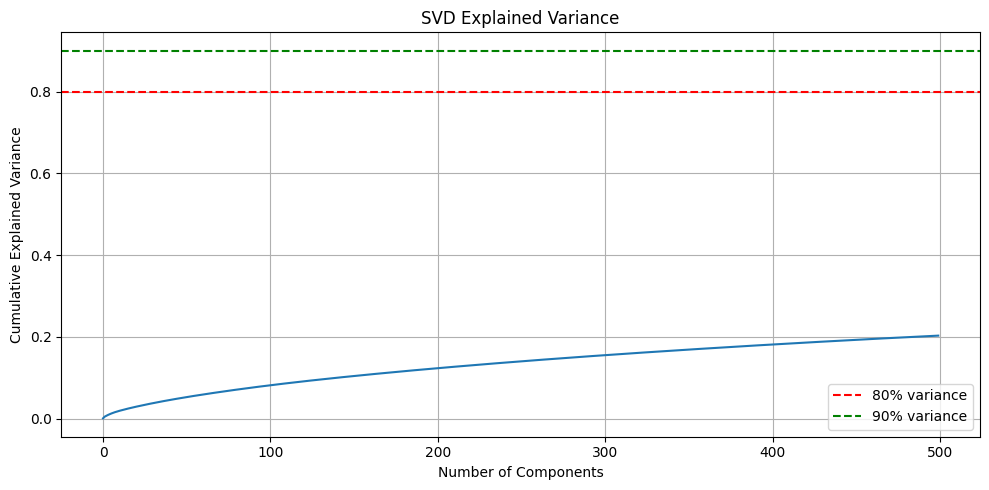

Components for 80% variance: 1
Components for 90% variance: 1


In [21]:
# Plot explained variance for SVD
svd_full = TruncatedSVD(n_components=500, random_state=42)
svd_full.fit(X_train_word)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(svd_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Explained Variance')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/svd_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Components for 80% variance: {np.argmax(np.cumsum(svd_full.explained_variance_ratio_) >= 0.8) + 1}")
print(f"Components for 90% variance: {np.argmax(np.cumsum(svd_full.explained_variance_ratio_) >= 0.9) + 1}")


In [22]:
# Dimensionality Reduction - NMF

nmf_components = [50, 100, 150]
nmf_models = {}

for n_comp in nmf_components:
    nmf = NMF(n_components=n_comp, random_state=42, max_iter=200)
    X_train_nmf = nmf.fit_transform(X_train_word)
    X_val_nmf = nmf.transform(X_val_word)
    
    nmf_models[n_comp] = {
        'model': nmf,
        'X_train': X_train_nmf,
        'X_val': X_val_nmf,
        'reconstruction_err': nmf.reconstruction_err_
    }
    
    print(f"NMF {n_comp} components:")
    print(f"  Shape: {X_train_nmf.shape}")
    print(f"  Reconstruction error: {nmf.reconstruction_err_:.4f}")


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF 50 components:
  Shape: (102000, 50)
  Reconstruction error: 309.9204
NMF 100 components:
  Shape: (102000, 100)
  Reconstruction error: 305.4218
NMF 150 components:
  Shape: (102000, 150)
  Reconstruction error: 301.9099


In [23]:
# 3.5 Auxiliary Feature Engineering - Document-Level Features

def extract_doc_features(text):
    """Extract document-level statistical features"""
    features = {}
    
    # Length features
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = len(sent_tokenize(text))
    
    # Complexity features
    words = text.split()
    features['avg_word_length'] = np.mean([len(w) for w in words]) if words else 0
    sentences = sent_tokenize(text)
    features['avg_sentence_length'] = np.mean([len(s.split()) for s in sentences]) if sentences else 0
    
    # Vocabulary richness (Type-Token Ratio)
    unique_words = set(words)
    features['ttr'] = len(unique_words) / len(words) if words else 0
    
    # Structural features
    features['punctuation_density'] = len(re.findall(r'[^\w\s]', text)) / len(text) if text else 0
    features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / len(text) if text else 0
    features['digit_ratio'] = sum(1 for c in text if c.isdigit()) / len(text) if text else 0
    
    # Metadata presence
    features['has_url'] = 1 if re.search(r'http\S+|www\.\S+', text) else 0
    features['has_email'] = 1 if re.search(r'\S+@\S+', text) else 0
    features['has_phone'] = 1 if re.search(r'\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', text) else 0
    
    return features

# Extract features for train and val
train_doc_features = train_df['text'].apply(extract_doc_features).apply(pd.Series)
val_doc_features = val_df['text'].apply(extract_doc_features).apply(pd.Series)

print(f"Document features shape: {train_doc_features.shape}")
print(f"\nFeature statistics:")
print(train_doc_features.describe())


Document features shape: (102000, 12)

Feature statistics:
          char_count     word_count  sentence_count  avg_word_length  \
count  102000.000000  102000.000000   102000.000000    102000.000000   
mean      236.606324      37.871020        1.320588         5.284513   
std        66.764765      10.117152        0.660906         0.687929   
min       100.000000       8.000000        1.000000         3.357143   
25%       196.000000      32.000000        1.000000         4.870968   
50%       232.000000      37.000000        1.000000         5.200000   
75%       266.000000      43.000000        1.000000         5.571429   
max      1009.000000     171.000000       15.000000        20.800000   

       avg_sentence_length            ttr  punctuation_density  \
count        102000.000000  102000.000000        102000.000000   
mean             32.005183       0.885159             0.030668   
std              10.437759       0.061849             0.019331   
min               3.142857  

In [24]:
# Linguistic Features using spaCy

def extract_linguistic_features(text):
    """Extract linguistic features using spaCy"""
    doc = nlp(text)
    features = {}
    
    # POS distribution
    pos_counts = {'NOUN': 0, 'VERB': 0, 'ADJ': 0, 'ADV': 0, 'PRON': 0}
    for token in doc:
        if token.pos_ in pos_counts:
            pos_counts[token.pos_] += 1
    
    total_tokens = len(doc)
    for pos, count in pos_counts.items():
        features[f'{pos.lower()}_ratio'] = count / total_tokens if total_tokens > 0 else 0
    
    # Dependency depth
    features['max_dep_depth'] = max([len(list(token.ancestors)) for token in doc]) if doc else 0
    
    # Named entities
    features['entity_count'] = len(doc.ents)
    features['entity_density'] = len(doc.ents) / total_tokens if total_tokens > 0 else 0
    
    return features

# Extract linguistic features for subset (spaCy is slow)
print("Extracting linguistic features (this may take a while)...")
train_ling_features = train_df['text'].head(1000).apply(extract_linguistic_features).apply(pd.Series)
val_ling_features = val_df['text'].head(200).apply(extract_linguistic_features).apply(pd.Series)

print(f"Linguistic features shape: {train_ling_features.shape}")
print(f"\nFeature statistics:")
print(train_ling_features.describe())


Extracting linguistic features (this may take a while)...
Linguistic features shape: (1000, 8)

Feature statistics:
        noun_ratio   verb_ratio    adj_ratio    adv_ratio   pron_ratio  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.196680     0.101248     0.063711     0.018591     0.025859   
std       0.071107     0.038932     0.040081     0.025289     0.028574   
min       0.020408     0.000000     0.000000     0.000000     0.000000   
25%       0.148936     0.075000     0.033333     0.000000     0.000000   
50%       0.191489     0.100000     0.058824     0.000000     0.022222   
75%       0.238095     0.125000     0.088399     0.029412     0.041667   
max       0.500000     0.275862     0.208333     0.166667     0.222222   

       max_dep_depth  entity_count  entity_density  
count    1000.000000   1000.000000     1000.000000  
mean        7.427000      6.312000        0.143364  
std         2.011646      3.166178        0.060401  
min  

In [25]:
# Scale auxiliary features
scaler = StandardScaler()
train_doc_features_scaled = scaler.fit_transform(train_doc_features)
val_doc_features_scaled = scaler.transform(val_doc_features)

print(f"Scaled document features shape: {train_doc_features_scaled.shape}")

# Concatenate with TF-IDF
X_train_augmented = sp.hstack([X_train_word, train_doc_features_scaled])
X_val_augmented = sp.hstack([X_val_word, val_doc_features_scaled])

print(f"Augmented features shape: {X_train_augmented.shape}")


Scaled document features shape: (102000, 12)
Augmented features shape: (102000, 50012)


In [26]:
# 3.6 Embedding-Based Features - Load pretrained embeddings

print("Loading pretrained GloVe embeddings...")
glove_vectors = api.load('glove-wiki-gigaword-100')
print(f"GloVe vocabulary size: {len(glove_vectors)}")
print(f"Vector dimension: {glove_vectors.vector_size}")

# Test embedding lookup
test_words = ['news', 'sports', 'business', 'technology']
for word in test_words:
    if word in glove_vectors:
        print(f"{word}: {glove_vectors[word][:5]}...")


Loading pretrained GloVe embeddings...
[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe vocabulary size: 400000
Vector dimension: 100
news: [-0.66842 -0.41713  0.42473 -0.9329  -0.36823]...
sports: [ 0.25178  0.21679 -0.18549 -0.60748 -0.5374 ]...
business: [ 0.034417 -0.078278 -0.26958  -0.28143  -0.045052]...
technology: [-0.12241   0.64795   0.43668   0.011368  0.50016 ]...


In [27]:
# Document embedding strategies

def document_embedding_mean(text, embedding_model):
    """Simple average of word vectors"""
    words = text.lower().split()
    vectors = [embedding_model[word] for word in words if word in embedding_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)

def document_embedding_tfidf_weighted(text, embedding_model, tfidf_vectorizer, tfidf_matrix, doc_idx):
    """TF-IDF weighted average of word vectors"""
    words = text.lower().split()
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = dict(zip(feature_names, tfidf_matrix[doc_idx].toarray().flatten()))
    
    weighted_vectors = []
    weights = []
    for word in words:
        if word in embedding_model and word in tfidf_scores:
            weighted_vectors.append(embedding_model[word] * tfidf_scores[word])
            weights.append(tfidf_scores[word])
    
    if weighted_vectors and sum(weights) > 0:
        return np.sum(weighted_vectors, axis=0) / sum(weights)
    else:
        return np.zeros(embedding_model.vector_size)

def document_embedding_max_pooling(text, embedding_model):
    """Element-wise max across word vectors"""
    words = text.lower().split()
    vectors = [embedding_model[word] for word in words if word in embedding_model]
    if vectors:
        return np.max(vectors, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)

def document_embedding_min_pooling(text, embedding_model):
    """Element-wise min across word vectors"""
    words = text.lower().split()
    vectors = [embedding_model[word] for word in words if word in embedding_model]
    if vectors:
        return np.min(vectors, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)

print("Document embedding functions defined")


Document embedding functions defined


In [28]:
# Generate document embeddings - Simple mean
print("Generating mean document embeddings...")
train_embeddings_mean = np.array([
    document_embedding_mean(text, glove_vectors) 
    for text in train_df['text']
])
val_embeddings_mean = np.array([
    document_embedding_mean(text, glove_vectors) 
    for text in val_df['text']
])

print(f"Train embeddings shape: {train_embeddings_mean.shape}")
print(f"Val embeddings shape: {val_embeddings_mean.shape}")


Generating mean document embeddings...
Train embeddings shape: (102000, 100)
Val embeddings shape: (18000, 100)


In [29]:
# Generate document embeddings - TF-IDF weighted
print("Generating TF-IDF weighted document embeddings...")
train_embeddings_tfidf = np.array([
    document_embedding_tfidf_weighted(text, glove_vectors, vectorizer_word, X_train_word, idx)
    for idx, text in enumerate(train_df['text'])
])
val_embeddings_tfidf = np.array([
    document_embedding_tfidf_weighted(text, glove_vectors, vectorizer_word, X_val_word, idx)
    for idx, text in enumerate(val_df['text'])
])

print(f"Train TF-IDF weighted embeddings shape: {train_embeddings_tfidf.shape}")
print(f"Val TF-IDF weighted embeddings shape: {val_embeddings_tfidf.shape}")


Generating TF-IDF weighted document embeddings...
Train TF-IDF weighted embeddings shape: (102000, 100)
Val TF-IDF weighted embeddings shape: (18000, 100)


In [30]:
# Generate document embeddings - Max pooling
print("Generating max pooling document embeddings...")
train_embeddings_max = np.array([
    document_embedding_max_pooling(text, glove_vectors) 
    for text in train_df['text']
])
val_embeddings_max = np.array([
    document_embedding_max_pooling(text, glove_vectors) 
    for text in val_df['text']
])

print(f"Train max pooling embeddings shape: {train_embeddings_max.shape}")
print(f"Val max pooling embeddings shape: {val_embeddings_max.shape}")


Generating max pooling document embeddings...
Train max pooling embeddings shape: (102000, 100)
Val max pooling embeddings shape: (18000, 100)


In [31]:
# Generate document embeddings - Concatenated (mean + max + min)
print("Generating concatenated document embeddings...")
train_embeddings_min = np.array([
    document_embedding_min_pooling(text, glove_vectors) 
    for text in train_df['text']
])
val_embeddings_min = np.array([
    document_embedding_min_pooling(text, glove_vectors) 
    for text in val_df['text']
])

train_embeddings_concat = np.hstack([train_embeddings_mean, train_embeddings_max, train_embeddings_min])
val_embeddings_concat = np.hstack([val_embeddings_mean, val_embeddings_max, val_embeddings_min])

print(f"Train concatenated embeddings shape: {train_embeddings_concat.shape}")
print(f"Val concatenated embeddings shape: {val_embeddings_concat.shape}")


Generating concatenated document embeddings...
Train concatenated embeddings shape: (102000, 300)
Val concatenated embeddings shape: (18000, 300)


In [32]:
# 3.7 Preprocessing Pipeline Variants - Define all configurations

pipeline_variants = {}

# 1. Baseline: TF-IDF word (1,2)-grams
pipeline_variants['baseline'] = {
    'name': 'Baseline: TF-IDF word (1,2)-grams',
    'X_train': X_train_word,
    'X_val': X_val_word,
    'vectorizer': vectorizer_word
}

# 2. Char-enhanced: Word (1,2) + Char (3,5) TF-IDF
pipeline_variants['char_enhanced'] = {
    'name': 'Char-enhanced: Word + Char TF-IDF',
    'X_train': X_train_hybrid,
    'X_val': X_val_hybrid,
    'vectorizer': (vectorizer_word, vectorizer_char)
}

# 3. Feature-selected: Chi2 top 20k
pipeline_variants['chi2_selected'] = {
    'name': 'Feature-selected: Chi2 top 20k',
    'X_train': X_train_chi2,
    'X_val': X_val_chi2,
    'vectorizer': vectorizer_word,
    'selector': chi2_selector
}

# 4. Dimensionality-reduced: SVD 300 components
pipeline_variants['svd_reduced'] = {
    'name': 'SVD 300 components',
    'X_train': svd_models[300]['X_train'],
    'X_val': svd_models[300]['X_val'],
    'vectorizer': vectorizer_word,
    'reducer': svd_models[300]['model']
}

# 5. Embedding-based: TF-IDF weighted GloVe
pipeline_variants['embedding_tfidf'] = {
    'name': 'Embedding: TF-IDF weighted GloVe',
    'X_train': train_embeddings_tfidf,
    'X_val': val_embeddings_tfidf,
    'embedding_model': glove_vectors
}

# 6. Embedding-based: Concatenated (mean + max + min)
pipeline_variants['embedding_concat'] = {
    'name': 'Embedding: Concatenated pooling',
    'X_train': train_embeddings_concat,
    'X_val': val_embeddings_concat,
    'embedding_model': glove_vectors
}

# 7. Augmented: Word TF-IDF + document features
pipeline_variants['augmented'] = {
    'name': 'Augmented: TF-IDF + doc features',
    'X_train': X_train_augmented,
    'X_val': X_val_augmented,
    'vectorizer': vectorizer_word,
    'scaler': scaler
}

print(f"Defined {len(pipeline_variants)} pipeline variants")
for name, config in pipeline_variants.items():
    print(f"  {name}: {config['X_train'].shape}")


Defined 7 pipeline variants
  baseline: (102000, 50000)
  char_enhanced: (102000, 100000)
  chi2_selected: (102000, 20000)
  svd_reduced: (102000, 300)
  embedding_tfidf: (102000, 100)
  embedding_concat: (102000, 300)
  augmented: (102000, 50012)


In [33]:
# Evaluate all pipeline variants with Logistic Regression

results = []
macro_f1_scorer = make_scorer(f1_score, average='macro')

for variant_name, config in pipeline_variants.items():
    print(f"\nEvaluating: {config['name']}")
    
    X_train = config['X_train']
    X_val = config['X_val']
    
    # Train logistic regression
    lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr.fit(X_train, train_df['label'])
    
    # Validation predictions
    val_pred = lr.predict(X_val)
    val_macro_f1 = f1_score(val_df['label'], val_pred, average='macro')
    val_accuracy = (val_pred == val_df['label']).mean()
    
    # Cross-validation on train
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(lr, X_train, train_df['label'], cv=cv, scoring=macro_f1_scorer, n_jobs=-1)
    
    results.append({
        'variant': variant_name,
        'name': config['name'],
        'val_macro_f1': val_macro_f1,
        'val_accuracy': val_accuracy,
        'cv_macro_f1_mean': cv_scores.mean(),
        'cv_macro_f1_std': cv_scores.std(),
        'feature_dim': X_train.shape[1],
        'sparsity': 1.0 - X_train.nnz / (X_train.shape[0] * X_train.shape[1]) if sp.issparse(X_train) else 0.0
    })
    
    print(f"  Val Macro-F1: {val_macro_f1:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  CV Macro-F1: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_macro_f1', ascending=False)
print("\n" + "="*80)
print("PIPELINE COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))



Evaluating: Baseline: TF-IDF word (1,2)-grams
  Val Macro-F1: 0.9207
  Val Accuracy: 0.9209
  CV Macro-F1: 0.9165 +/- 0.0025

Evaluating: Char-enhanced: Word + Char TF-IDF
  Val Macro-F1: 0.9245
  Val Accuracy: 0.9247
  CV Macro-F1: 0.9199 +/- 0.0024

Evaluating: Feature-selected: Chi2 top 20k
  Val Macro-F1: 0.9170
  Val Accuracy: 0.9172
  CV Macro-F1: 0.9143 +/- 0.0026

Evaluating: SVD 300 components
  Val Macro-F1: 0.8866
  Val Accuracy: 0.8869
  CV Macro-F1: 0.8857 +/- 0.0022

Evaluating: Embedding: TF-IDF weighted GloVe
  Val Macro-F1: 0.8792
  Val Accuracy: 0.8794
  CV Macro-F1: 0.8767 +/- 0.0020

Evaluating: Embedding: Concatenated pooling
  Val Macro-F1: 0.8913
  Val Accuracy: 0.8915
  CV Macro-F1: 0.8867 +/- 0.0030

Evaluating: Augmented: TF-IDF + doc features
  Val Macro-F1: 0.9203
  Val Accuracy: 0.9205
  CV Macro-F1: 0.9168 +/- 0.0028

PIPELINE COMPARISON RESULTS
         variant                              name  val_macro_f1  val_accuracy  cv_macro_f1_mean  cv_macro_f1_s

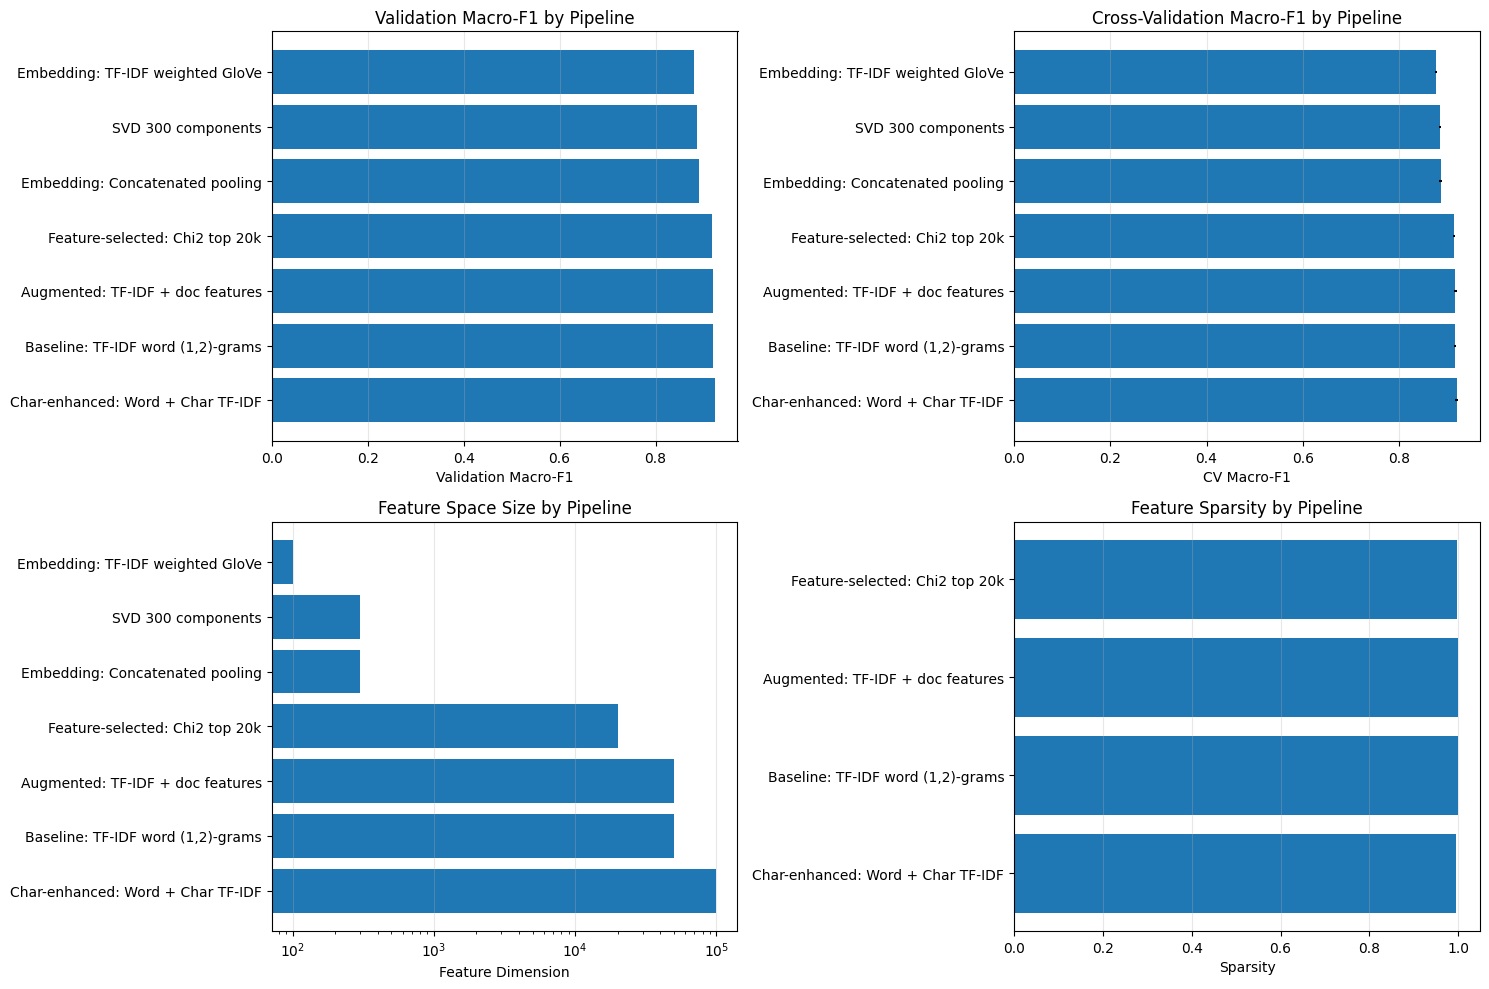

In [35]:
# Visualize pipeline comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Val Macro-F1
axes[0, 0].barh(results_df['name'], results_df['val_macro_f1'])
axes[0, 0].set_xlabel('Validation Macro-F1')
axes[0, 0].set_title('Validation Macro-F1 by Pipeline')
axes[0, 0].grid(axis='x', alpha=0.3)

# CV Macro-F1 with error bars
axes[0, 1].barh(results_df['name'], results_df['cv_macro_f1_mean'], xerr=results_df['cv_macro_f1_std'])
axes[0, 1].set_xlabel('CV Macro-F1')
axes[0, 1].set_title('Cross-Validation Macro-F1 by Pipeline')
axes[0, 1].grid(axis='x', alpha=0.3)

# Feature dimensionality
axes[1, 0].barh(results_df['name'], results_df['feature_dim'])
axes[1, 0].set_xlabel('Feature Dimension')
axes[1, 0].set_title('Feature Space Size by Pipeline')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(axis='x', alpha=0.3)

# Sparsity
sparse_df = results_df[results_df['sparsity'] > 0]
axes[1, 1].barh(sparse_df['name'], sparse_df['sparsity'])
axes[1, 1].set_xlabel('Sparsity')
axes[1, 1].set_title('Feature Sparsity by Pipeline')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/pipeline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
# Save all vectorizers and transformers
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(exist_ok=True)

# Save TF-IDF vectorizers
joblib.dump(vectorizer_word, MODELS_DIR / 'tfidf_word_12.pkl')
joblib.dump(vectorizer_char, MODELS_DIR / 'tfidf_char_35.pkl')

# Save feature selectors
joblib.dump(chi2_selector, MODELS_DIR / 'chi2_selector_20k.pkl')
joblib.dump(mi_selector, MODELS_DIR / 'mi_selector_20k.pkl')

# Save dimensionality reducers
joblib.dump(svd_models[300]['model'], MODELS_DIR / 'svd_300.pkl')
joblib.dump(nmf_models[100]['model'], MODELS_DIR / 'nmf_100.pkl')

# Save scaler
joblib.dump(scaler, MODELS_DIR / 'doc_features_scaler.pkl')

print("All vectorizers and transformers saved")


All vectorizers and transformers saved


In [37]:
# Save processed feature matrices
FEATURES_DIR = Path('features')
FEATURES_DIR.mkdir(exist_ok=True)

# Save sparse matrices
sp.save_npz(FEATURES_DIR / 'X_train_word.npz', X_train_word)
sp.save_npz(FEATURES_DIR / 'X_val_word.npz', X_val_word)
sp.save_npz(FEATURES_DIR / 'X_train_char.npz', X_train_char)
sp.save_npz(FEATURES_DIR / 'X_val_char.npz', X_val_char)
sp.save_npz(FEATURES_DIR / 'X_train_hybrid.npz', X_train_hybrid)
sp.save_npz(FEATURES_DIR / 'X_val_hybrid.npz', X_val_hybrid)

# Save dense matrices
np.save(FEATURES_DIR / 'train_embeddings_mean.npy', train_embeddings_mean)
np.save(FEATURES_DIR / 'val_embeddings_mean.npy', val_embeddings_mean)
np.save(FEATURES_DIR / 'train_embeddings_tfidf.npy', train_embeddings_tfidf)
np.save(FEATURES_DIR / 'val_embeddings_tfidf.npy', val_embeddings_tfidf)
np.save(FEATURES_DIR / 'train_embeddings_concat.npy', train_embeddings_concat)
np.save(FEATURES_DIR / 'val_embeddings_concat.npy', val_embeddings_concat)

# Save auxiliary features
train_doc_features.to_csv(FEATURES_DIR / 'train_doc_features.csv', index=False)
val_doc_features.to_csv(FEATURES_DIR / 'val_doc_features.csv', index=False)

# Save results
results_df.to_csv(FEATURES_DIR / 'pipeline_comparison_results.csv', index=False)

print("All feature matrices saved")


All feature matrices saved


In [38]:
# Summary statistics
print("\n" + "="*80)
print("PREPROCESSING PIPELINE SUMMARY")
print("="*80)
print(f"\nBest pipeline by Validation Macro-F1:")
best_variant = results_df.iloc[0]
print(f"  {best_variant['name']}")
print(f"  Val Macro-F1: {best_variant['val_macro_f1']:.4f}")
print(f"  CV Macro-F1: {best_variant['cv_macro_f1_mean']:.4f} +/- {best_variant['cv_macro_f1_std']:.4f}")
print(f"  Feature dimension: {int(best_variant['feature_dim'])}")

print(f"\nTotal pipeline variants evaluated: {len(results_df)}")
print(f"Feature matrices saved: {len(list(FEATURES_DIR.glob('*.npz'))) + len(list(FEATURES_DIR.glob('*.npy')))}")
print(f"Vectorizers saved: {len(list(MODELS_DIR.glob('*.pkl')))}")



PREPROCESSING PIPELINE SUMMARY

Best pipeline by Validation Macro-F1:
  Char-enhanced: Word + Char TF-IDF
  Val Macro-F1: 0.9245
  CV Macro-F1: 0.9199 +/- 0.0024
  Feature dimension: 100000

Total pipeline variants evaluated: 7
Feature matrices saved: 12
Vectorizers saved: 7
